In [1]:
# ============================================================
# Reinforcement Learning Agent for Student Performance Support
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import joblib
from tqdm import tqdm

# ============================================================
# 1. Load Dataset
# ============================================================
df = joblib.load(r"..\data\preprocessed_encoded_data.pkl")
df.head()

required_cols = [
    "Battery Capacity (kWh)",
    "Charging Station Location_Chicago",
    "Charging Station Location_Houston",
    "Charging Station Location_Los Angeles",
    "Charging Station Location_New York",
    "Charging Station Location_San Francisco",
    "Charger Type",
    "Time of Day"
]

In [3]:
# Discretizing Continuous features
df["Battery_Level"] = pd.qcut(df["Battery Capacity (kWh)"], 2, labels=[0, 1]).astype(int)
location_cols = [
    "Charging Station Location_Chicago",
    "Charging Station Location_Houston",
    "Charging Station Location_Los Angeles",
    "Charging Station Location_New York",
    "Charging Station Location_San Francisco"
]
df["Location_State"] = df[location_cols].idxmax(axis=1).str.replace("Charging Station Location_", "")
location_mapping = {
    "Chicago": 0,
    "Houston": 1,
    "Los Angeles": 2,
    "New York": 3,
    "San Francisco": 4
}
df["Location_State"] = df["Location_State"].map(location_mapping)


In [4]:
df["State"] = list(
    zip(
        df["Battery_Level"],
        df["Location_State"],
        df["Charger Type"],
        df["Time of Day"]
    )
)
df["State"]

0       (1, 1, 0, 1)
1       (1, 4, 1, 2)
2       (1, 4, 2, 2)
3       (0, 1, 1, 1)
4       (0, 2, 1, 2)
            ...     
9315    (1, 3, 0, 3)
9316    (0, 0, 2, 1)
9317    (1, 2, 1, 2)
9318    (1, 3, 0, 2)
9319    (1, 2, 1, 3)
Name: State, Length: 9320, dtype: object

In [5]:
ACTION_NAMES = {
    0: "Do Nothing",
    1: "Recommend Changing Location",
    2: "Delay Charging"
}
n_actions = 3

In [6]:
df["Reward"] = -df["Charging Cost (USD)"]

In [ ]:
states = list(itertools.product([0,1], 
                                [0,1,2,3,4], 
                                [0,1,2], 
                                [0,1,2,3], repeat=1))
state_to_index = {s: i for i, s in enumerate(states)}
n_states = len(states)
Q = np.zeros((n_states, n_actions))

In [55]:
# ============================================================
# 6. Q-learning Hyperparameters
# ============================================================
episodes = 10000
alpha = 0.2
gamma = 0.0        # single-step learning
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.97

reward_history = []
q_history = []

# Group data for fast reward sampling
grouped = {}
for s in states:
    for a in range(n_actions):
        grouped[(s, a)] = df[df["State"] == s]
        

In [56]:
# Initialize progress bar
pbar = tqdm(range(episodes), desc="Training RL Agent")

for ep in pbar:

    # Random state (offline RL from dataset)
    s = random.choice(states)
    s_idx = state_to_index[s]

    # Epsilon-greedy action selection
    if np.random.rand() < epsilon:
        a = np.random.randint(n_actions)
    else:
        a = int(np.argmax(Q[s_idx]))

    # Reward sampling
    candidates = grouped[(s, a)]
    if len(candidates) == 0:
        r = 0.0
    else:
        r = float(candidates.sample(1)["Reward"].iloc[0])

    # Q update
    Q[s_idx, a] += alpha * (r - Q[s_idx, a])

    reward_history.append(r)
    q_history.append(Q.copy())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    # Update progress bar with current stats every 100 episodes
    if ep % 100 == 0:
        avg_reward = np.mean(reward_history[-100:]) if len(reward_history) >= 100 else np.mean(reward_history)
        pbar.set_postfix({
            'Avg Reward': f'{avg_reward:.2f}',
            'Epsilon': f'{epsilon:.3f}'
        })

Training RL Agent: 100%|██████████| 10000/10000 [00:00<00:00, 49955.74it/s, Avg Reward=0.00, Epsilon=0.050]


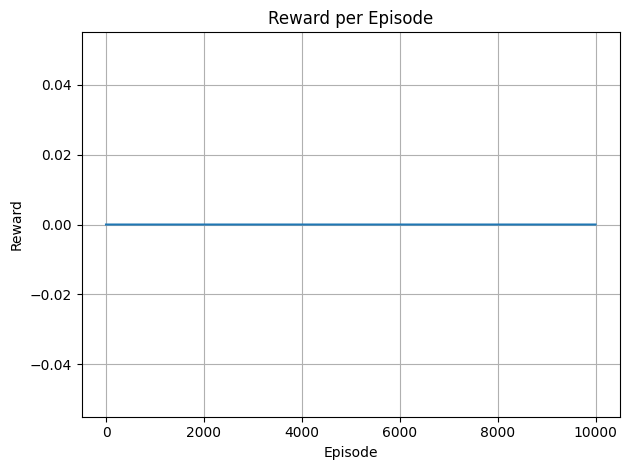

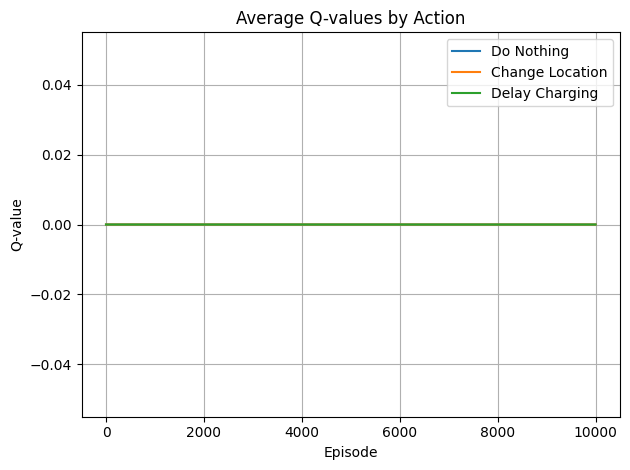

In [57]:
# ============================================================
# 8. Training Visualization
# ============================================================
plt.figure()
plt.plot(reward_history)
plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot([q.mean(axis=0)[0] for q in q_history], label="Do Nothing")
plt.plot([q.mean(axis=0)[1] for q in q_history], label="Change Location")
plt.plot([q.mean(axis=0)[2] for q in q_history], label="Delay Charging")
plt.title("Average Q-values by Action")
plt.xlabel("Episode")
plt.ylabel("Q-value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
# ============================================================
# 9. Learned Policy
# ============================================================
print("\nLearned Policy (Best Action per State):\n")

for state, idx in state_to_index.items():
    best_action = int(np.argmax(Q[idx]))
    print(f"State {state} → {ACTION_NAMES[best_action]}")

print("\nFinal Mean Q-values by Action:")
for a in range(n_actions):
    print(f"{ACTION_NAMES[a]}: {Q.mean(axis=0)[a]:.3f}")


Learned Policy (Best Action per State):

State (0, 0, 0, 0) → Do Nothing
State (0, 0, 0, 1) → Do Nothing
State (0, 0, 1, 0) → Do Nothing
State (0, 0, 1, 1) → Do Nothing
State (0, 1, 0, 0) → Do Nothing
State (0, 1, 0, 1) → Do Nothing
State (0, 1, 1, 0) → Do Nothing
State (0, 1, 1, 1) → Do Nothing
State (1, 0, 0, 0) → Do Nothing
State (1, 0, 0, 1) → Do Nothing
State (1, 0, 1, 0) → Do Nothing
State (1, 0, 1, 1) → Do Nothing
State (1, 1, 0, 0) → Do Nothing
State (1, 1, 0, 1) → Do Nothing
State (1, 1, 1, 0) → Do Nothing
State (1, 1, 1, 1) → Do Nothing

Final Mean Q-values by Action:
Do Nothing: 0.000
Recommend Changing Location: 0.000
Delay Charging: 0.000


In [ ]:
def recommend_action(battery_capacity, location_idx, charger_type, time_of_day):
    """
    Input raw student values
    Output recommended action name
    """

    # Convert input to low(0) / high(1) using dataset medians
    battery_level  = int(battery_capacity >= df["Battery Capacity (kWh)"].median())
    # Create location one-hot
    location_one_hot = [0, 0, 0, 0, 0]
    location_one_hot[location_idx] = 1
    
    state = (
        battery_level,
        location_idx,     
        int(charger_type),
        int(time_of_day)
    )


    if state not in state_to_index:
        print(f"Warning: State {state} not found in training data.")
        print(f"Available states: {len(state_to_index)}")
        return "Do Nothing"  # Default action
    state_idx = state_to_index[state]
    best_action = int(np.argmax(Q[state_idx]))

    return ACTION_NAMES[best_action]

In [58]:
# Test with New York (location_idx=3)
action = recommend_action(
    battery_capacity=35,
    location_idx=3,  # New York
    charger_type=1,
    time_of_day=2
)
print(f"Recommended action: {action}")

# Test a few more scenarios
test_cases = [
    {"battery_capacity": 80, "location_idx": 0, "charger_type": 0, "time_of_day": 0},  # High battery, Chicago, off-peak
    {"battery_capacity": 20, "location_idx": 2, "charger_type": 2, "time_of_day": 2},  # Low battery, LA, peak time
    {"battery_capacity": 50, "location_idx": 4, "charger_type": 1, "time_of_day": 1},  # Medium battery, SF
]

for i, test in enumerate(test_cases, 1):
    result = recommend_action(**test)
    print(f"Test {i}: {result}")

Available states: 16
Recommended action: Do Nothing
Test 1: Do Nothing
Available states: 16
Test 2: Do Nothing
Available states: 16
Test 3: Do Nothing


In [32]:
# First, let's check what states actually exist in your data
print("Checking your dataset states:")
print(f"Total unique states: {len(states)}")
print(f"\nFirst 10 states in dataset:")
for i, s in enumerate(list(states)[:10]):
    print(f"{i}: {s}")

# Check what combinations exist for New York (location_idx=3)
ny_states = [s for s in states if s[4] == 1]  # Index 4 is New York
print(f"\nStates with New York location: {len(ny_states)}")
if len(ny_states) > 0:
    print("Example New York states:")
    for s in ny_states[:5]:
        print(s)

# Check your actual data
print("\nActual data sample:")
print(df[["Battery_Level", "Charging Station Location_New York", "Charger Type", "Time of Day", "State"]].head(20))

Checking your dataset states:
Total unique states: 16

First 10 states in dataset:
0: (0, 0, 0, 0)
1: (0, 0, 0, 1)
2: (0, 0, 1, 0)
3: (0, 0, 1, 1)
4: (0, 1, 0, 0)
5: (0, 1, 0, 1)
6: (0, 1, 1, 0)
7: (0, 1, 1, 1)
8: (1, 0, 0, 0)
9: (1, 0, 0, 1)


IndexError: tuple index out of range